# Projeto final Codenation

## Objetivo

O objetivo deste produto é fornecer um serviço automatizado que recomenda leads para um usuário dado sua atual lista de clientes (Portfólio).

## Contextualização
Algumas empresas gostariam de saber quem são as demais empresas em um determinado mercado (população) que tem maior probabilidade se tornarem seus próximos clientes. Ou seja, a sua solução deve encontrar no mercado quem são os leads mais aderentes dado as características dos clientes presentes no portfólio do usuário.

Além disso, sua solução deve ser agnóstica ao usuário. Qualquer usuário com uma lista de clientes que queira explorar esse mercado pode extrair valor do serviço.

Para o desafio, deverão ser consideradas as seguintes bases:

- Mercado: Base com informações sobre as empresas do Mercado a ser considerado. 
- Portfolio 1: Ids dos clientes da empresa 1
- Portfolio 2: Ids dos clientes da empresa 2
- Portfolio 3: Ids dos clientes da empresa 3

Obs: todas as empresas(ids) dos portfolios estão contidos no Mercado(base de população).

# Solução

1. Fase preliminar
    1. Defininindo o problema de negócio
    2. Entendimento analitico do problema;
    3. Definir arquitetura tecnologica;
2. Fase exploratória
    1. Entendimento dos dados
    2. Processamento dos dados
    3. Modelagem dos dados
3. Fase de produção
    1. Avaliação
    2. Implantação
    3. Monitoramento


Referência: [DEFINING THE PROJECT](http://drunkendatascience.com/the-data-science-process-post-2-defining-the-project/)

## Defininindo o problema de negócio

Dado uma lista de potenciais clientes extraido de um mercado definido, o sistema deve recomendar os clientes que possuem maior probabilidade de aderir ao seu negócio levando em consideração o seu portifolio de clientes atual do mercado em questão.

## Entendimento analitico do problema
O problema se trata de recomendação sem feedback explicito. A proposta de solução será a realização de clusterização para analise dos perfis de clientes de uma empresa e realizar a recomendações das empresas mais semelhantes utilizando alguma metrica de distância, por exemplo, euclidiana.
- Diminuiremos a dimensionalidade
- Não temos a resposta
- Estamos recomendando

São **leads** os potenciais clientes de uma marca que demonstram interesse em usar o seu produto ou serviço

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Configuration of pandas and seaborn
pd.set_option('display.max_columns', 0)
sns.set()

In [2]:
# configure file path
current_dir = os. getcwd() 
data_path = os.path.join(current_dir,'data')

print(data_path)

/home/johnnes/codenation/projeto-pratico/data


In [3]:
# Readind data
estaticos_market = pd.read_csv(os.path.join(data_path, 'estaticos_market.csv'), index_col=0)

portifolio1 = pd.read_csv(os.path.join(data_path, 'estaticos_portfolio1.csv'), index_col=0)
portifolio2 = pd.read_csv(os.path.join(data_path, 'estaticos_portfolio2.csv'), index_col=0)
portifolio3 = pd.read_csv(os.path.join(data_path, 'estaticos_portfolio3.csv'), index_col=0)

features_dictionary = pd.read_csv(os.path.join(data_path, 'features_dictionary.csv'), sep=';')

## Funções padrões para ajuda

In [4]:
"""
Função com intenção de obter a descrição de uma coluna especifica dos dados fonte.
Parâmetros:
    feature: String
Retorno:
    String
"""
def help_feature(feature=None):
    try:
        print(features_dictionary[features_dictionary.feature == feature].description.values[0])
    except IndexError:
        print('Variável não encontrada no dicionário')

"""
Função que retorna a estatistica do dataframe em relação os seus nulos por coluna
Parâmetros:
    dataframe: Pandas.DataFrame
Retorno:
    Pandas.DataFrame
"""
def describe_null_dataframe(dataframe):
    # Calculado a quantidade de nulos por coluna
    return pd.DataFrame({
        'column': list(dataframe.columns),
        'columns_nptype': dataframe.dtypes.values,
        'quantity_null': list(dataframe.isnull().sum()),
        'percent_null': list(dataframe.isnull().sum()/dataframe.shape[0])
    }).sort_values('percent_null', ascending= False)

"""
Função que com os ids retorna um dataframe com os dados do dataframe de recurso.
Parâmetros:
    dataframe_dados: Pandas.DataFrame
    dataframe_ids: Pandas.DataFrame
"""
def create_portifolio(dataframe_dados, dataframe_ids):
    return dataframe_ids[['id']].join(dataframe_dados.set_index('id'), on='id', how='inner')

In [5]:
print(f'estaticos_market: {estaticos_market.shape}')
print(f'portifolio1: {portifolio1.shape}')
print(f'portifolio2: {portifolio2.shape}')
print(f'portifolio3: {portifolio3.shape}')

estaticos_market: (462298, 181)
portifolio1: (555, 181)
portifolio2: (566, 1)
portifolio3: (265, 1)


# Preparando os dados de outros portifolios

In [6]:
portifolio2 = create_portifolio(estaticos_market, portifolio2)
portifolio3 = create_portifolio(estaticos_market, portifolio3)

In [7]:
estaticos_market_info = describe_null_dataframe(estaticos_market)

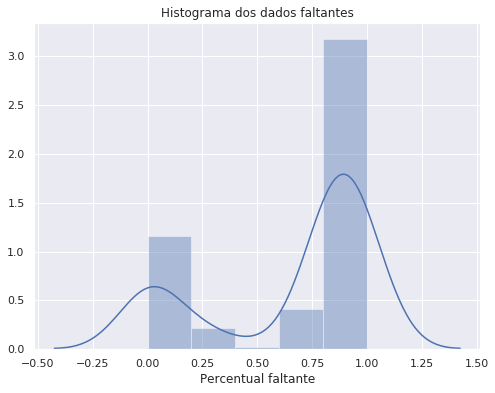

In [8]:
plt.figure(figsize=(8, 6))
ax = sns.distplot(estaticos_market_info.percent_null)

plt.title('Histograma dos dados faltantes')
plt.xlabel('Percentual faltante')
plt.show()

In [9]:
features_notnull = estaticos_market_info[estaticos_market_info.percent_null==0].column.values
features_withnull = estaticos_market_info[estaticos_market_info.percent_null!=0].column.values
features_notnull

array(['id', 'fl_matriz', 'fl_me', 'de_natureza_juridica', 'sg_uf',
       'natureza_juridica_macro', 'de_ramo', 'idade_empresa_anos',
       'idade_emp_cat', 'fl_sa', 'fl_rm', 'fl_epp', 'fl_mei', 'fl_ltda',
       'fl_st_especial', 'fl_email', 'fl_telefone', 'qt_filiais'],
      dtype=object)

In [10]:
features_withnull

array(['qt_alteracao_socio_total', 'qt_alteracao_socio_90d',
       'grau_instrucao_macro_desconhecido', 'qt_alteracao_socio_180d',
       'qt_alteracao_socio_365d', 'coligada_mais_antiga_baixada',
       'coligada_mais_nova_baixada', 'idade_media_coligadas_baixadas',
       'vl_total_veiculos_antt', 'vl_total_tancagem',
       'vl_total_veiculos_antt_grupo', 'vl_total_tancagem_grupo',
       'grau_instrucao_macro_analfabeto', 'idade_ate_18',
       'qt_socios_st_suspensa', 'vl_potenc_cons_oleo_gas',
       'qt_socios_pj_baixados', 'qt_socios_pj_nulos',
       'qt_socios_pj_suspensos', 'qt_socios_pj_inaptos',
       'vl_idade_media_socios_pj', 'vl_idade_minima_socios_pj',
       'vl_idade_maxima_socios_pj', 'qt_socios_pj_ativos', 'qt_art',
       'qt_socios_pep', 'idade_acima_de_58', 'idade_de_54_a_58',
       'idade_de_49_a_53', 'total_filiais_coligados',
       'media_filiais_coligados', 'max_filiais_coligados',
       'min_filiais_coligados',
       'grau_instrucao_macro_escolaridad

## Preparando os dados

Esta preparação consiste em remover todas e qualquer coluna que contenha um valor faltante para a realização de uma clusterização dos dados

In [11]:
# Drop columns contained NAN
estaticos_market_processed = estaticos_market.drop(features_withnull, axis=1)

# Save ids and after dropping
estaticos_market_id = estaticos_market_processed.id
estaticos_market_processed = estaticos_market_processed.drop(['id'], axis=1)

In [12]:
# Converting booleans data in int
estaticos_market_processed_bool = estaticos_market_processed.select_dtypes(include='bool').replace({
    True: 1, False: 0
})

estaticos_market_processed[estaticos_market_processed_bool.columns] = estaticos_market_processed_bool

In [13]:
# Applied one-hot-encoding
estaticos_market_processed_onehot = ['de_natureza_juridica', 'sg_uf', 'natureza_juridica_macro', 
                                     'de_ramo', 'idade_emp_cat', 'fl_rm']
estaticos_market_processed = pd.get_dummies(estaticos_market_processed, 
                                            columns=estaticos_market_processed_onehot)

In [14]:
estaticos_market_processed.head()

,fl_matriz,idade_empresa_anos,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,qt_filiais,de_natureza_juridica_ASSOCIACAO PRIVADA,de_natureza_juridica_AUTARQUIA ESTADUAL OU DO DISTRITO FEDERAL,de_natureza_juridica_AUTARQUIA FEDERAL,de_natureza_juridica_AUTARQUIA MUNICIPAL,de_natureza_juridica_CANDIDATO A CARGO POLITICO ELETIVO,de_natureza_juridica_CLUBE FUNDO DE INVESTIMENTO,de_natureza_juridica_COMUNIDADE INDIGENA,de_natureza_juridica_CONDOMINIO EDILICIO,de_natureza_juridica_CONSORCIO DE EMPREGADORES,de_natureza_juridica_CONSORCIO DE SOCIEDADES,de_natureza_juridica_CONSORCIO PUBDE DIREITO PUB ASS PUB,de_natureza_juridica_CONSORCIO PUBLICO DE DIREITO PRIVADO,de_natureza_juridica_COOPERATIVA,de_natureza_juridica_EMPRESA INDIVIDUAL DE RESPONSABILIDADE LIMITADA DE NATUREZA EMPRESARIA,de_natureza_juridica_EMPRESA INDIVIDUAL DE RESPONSABILIDADE LIMITADA DE NATUREZA SIMPLES,de_natureza_juridica_EMPRESA INDIVIDUAL IMOBILIARIA,de_natureza_juridica_EMPRESA PUBLICA,de_natureza_juridica_EMPRESARIO INDIVIDUAL,de_natureza_juridica_ENTIDADE DE MEDIACAO E ARBITRAGEM,de_natureza_juridica_ENTIDADE SINDICAL,de_natureza_juridica_ESTABELECIMENTO NO BRASIL DE FUNDACAO OU ASSOCIACAO ESTRANGEIRAS,de_natureza_juridica_ESTABELECIMENTO NO BRASIL DE SOCIEDADE ESTRANGEIRA,de_natureza_juridica_ESTADO OU DISTRITO FEDERAL,de_natureza_juridica_FRENTE PLEBISCITARIA OU REFERENDARIA,de_natureza_juridica_FUNDACAO PRIVADA,de_natureza_juridica_FUNDACAO PUB DE DIREITO PUB EST OU DO DF,de_natureza_juridica_FUNDACAO PUBLICA DE DIREITO PRIVADO FEFERAL,de_natureza_juridica_FUNDACAO PUBLICA DE DIREITO PRIVADO MUNICIPAL,de_natureza_juridica_FUNDACAO PUBLICA DE DIREITO PUB MUNICIPAL,...,de_ramo_ATIVIDADES IMOBILIARIAS,de_ramo_BENS DE CONSUMO,de_ramo_COMERCIO E REPARACAO DE VEICULOS,de_ramo_COMERCIO POR ATACADO,de_ramo_COMERCIO VAREJISTA,"de_ramo_CULTURA, ESPORTE E RECREACAO",de_ramo_ELETRICIDADE E GAS,de_ramo_ELETROELETRONICOS,de_ramo_FARMACEUTICA,de_ramo_INDUSTRIA AUTOMOTIVA,de_ramo_INDUSTRIA DA CONSTRUCAO,de_ramo_INDUSTRIA DIGITAL,de_ramo_INDUSTRIAS EXTRATIVAS,de_ramo_ORGANISMOS INTERNACIONAIS,de_ramo_OUTROS,de_ramo_PAPEL E CELULOSE,de_ramo_PRODUTOS DE AGROPECUARIA,de_ramo_QUIMICA-PETROQUIMICA,"de_ramo_SEGUROS, PLANOS DE PREVIDENCIA E PLANOS DE SAUDE",de_ramo_SERVICOS ADMINISTRATIVOS,de_ramo_SERVICOS DE ALOJAMENTO/ALIMENTACAO,de_ramo_SERVICOS DE EDUCACAO,de_ramo_SERVICOS DE SANEAMENTO BASICO,de_ramo_SERVICOS DE SAUDE,de_ramo_SERVICOS DIVERSOS,de_ramo_SERVICOS FINANCEIROS,"de_ramo_SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",de_ramo_SERVICOS SOCIAIS,de_ramo_SIDERURGICA-METALURGIA,de_ramo_TELECOM,de_ramo_TEXTEIS,"de_ramo_TRANSPORTE, ARMAZENAGEM E CORREIO",idade_emp_cat_1 a 5,idade_emp_cat_10 a 15,idade_emp_cat_15 a 20,idade_emp_cat_5 a 10,idade_emp_cat_<= 1,idade_emp_cat_> 20,fl_rm_NAO,fl_rm_SIM
0,1,14.457534,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,1,1.463014,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,1,7.093151,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,1,6.512329,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,1,3.200000,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


In [15]:
# https://medium.com/data-hackers/normalizar-ou-padronizar-as-vari%C3%A1veis-3b619876ccc9
scaler = MinMaxScaler()

#estaticos_market_processed['idade_empresa_anos'] =  scaler.fit_transform(estaticos_market_processed.idade_empresa_anos.values.reshape(-1, 1))


estaticos_market_processed =  pd.DataFrame(scaler.fit_transform(estaticos_market_processed), columns= estaticos_market_processed.columns)

# Baseline

Futuramente construir pipeline: https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65

In [16]:
X = estaticos_market_processed

n_components = 20
model_pca = PCA(n_components=n_components)
X_pca = model_pca.fit_transform(X)

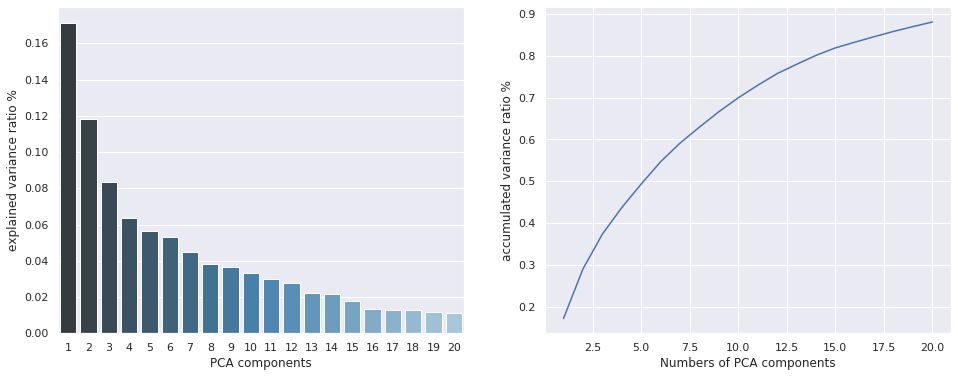

In [17]:
x_axis = np.arange(1, n_components+1)
y_axis = model_pca.explained_variance_ratio_

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
ax = sns.barplot(x=x_axis, y=y_axis, palette='Blues_d')
plt.xlabel('PCA components')
plt.ylabel('explained variance ratio %')

plt.subplot(1, 2, 2)
y_axis = [np.sum(y_axis[:i]) for i in range(1, n_components+1)]
ax_line = sns.lineplot(x=x_axis, y=y_axis)
plt.xlabel('Numbers of PCA components')
plt.ylabel('accumulated variance ratio %')
plt.show()

In [18]:
X = estaticos_market_processed

n_components = 2
model_pca = PCA(n_components=2)
X_pca = model_pca.fit_transform(X)

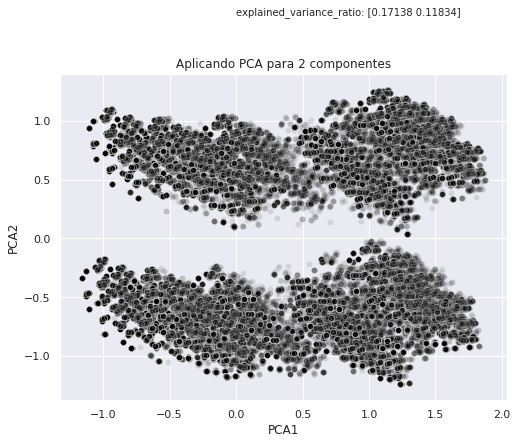

In [19]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], color='black', alpha=0.1)
ax.text(0, 1.9, f'explained_variance_ratio: {np.around(model_pca.explained_variance_ratio_, 5)}', fontsize=10) 

plt.title('Aplicando PCA para 2 componentes')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [20]:
model_kmeans = KMeans(init='k-means++', n_clusters=4, random_state=0)

#model_kmeans.fit(X)
#y_pred = model_kmeans.predict(X)
#y_centroid = model_pca.transform(model_kmeans.cluster_centers_)

model_kmeans.fit(X_pca)
y_pred = model_kmeans.predict(X_pca)
y_centroid = model_kmeans.cluster_centers_

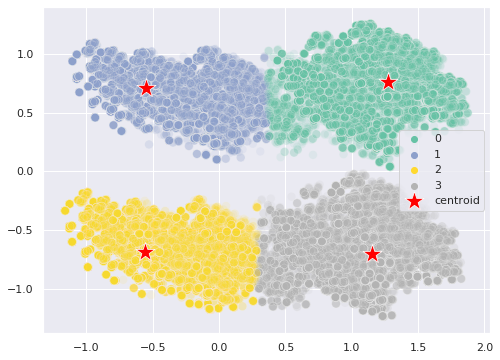

In [21]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred, s=75, palette='Set2', alpha=0.1)
ax = sns.scatterplot(x=y_centroid[:, 0], y=y_centroid[:, 1], 
                     marker='*', s=400, color='red', label='centroid')

## Contruindo o pipeline

Esta fase do projeto se faz necessário para que possa realizar experimentos de forma simples

In [22]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self, feature_names):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None):
        return X[self._feature_names].copy()
    
    def fit_transform(self, X, y = None):
        return self.fit(X, y).transform(X, y)
    
    # Remove warning
    def _get_param_names(self):
        return []

In [23]:
class FeaturesConversor(BaseEstimator, TransformerMixin):
    def __init__(self, columns, function):
        """
        Function is applied in columns
        Params:
            columns: array os list
            function: function python
        returns:
            X_new: Dataframe
        """
        self._columns = columns
        self._function = function
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for column in self._columns:
            X[column] = X[column].apply(self._function)
        
        return X
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)
    
    # Remove warning
    def _get_param_names(self):
        return []

In [24]:
#Categrical features to pass down the categorical pipeline 
cateforical_features = ['de_natureza_juridica', 'sg_uf', 'natureza_juridica_macro', 
                        'de_ramo', 'idade_emp_cat', 'fl_rm']

#Numerical features to pass down the numerical pipeline 
numerical_features = ['idade_empresa_anos', 'qt_filiais']

#Booleans features to convert. obs:fl_rm 
bool_features = ['fl_matriz', 'fl_me', 'fl_sa', 'fl_epp', 'fl_mei', 
                 'fl_ltda', 'fl_st_especial', 'fl_email', 'fl_telefone']
def boolean_conversor(x):
    return 1 if x == True else (0 if x == False else x)

#Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps = [('cat_selector', FeatureSelector(cateforical_features)),
                                         ('one_hot_encoder', OneHotEncoder(sparse = False))])
    
#Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       #('num_imputer', SimpleImputer(strategy = 'median') ),
                                       ('minmax_scaler', MinMaxScaler())])

boolean_pipeline = Pipeline(steps = [('boolean_selector', FeatureSelector(bool_features)),
                                     ('boolean_conversor', FeaturesConversor(bool_features, boolean_conversor))])

#Combining numerical and categorical pipeline into one full big pipeline horizontally using FeatureUnion
transformer_pipeline = FeatureUnion(transformer_list = [('boolean_pipeline', boolean_pipeline),
                                                        ('categorical_pipeline', categorical_pipeline), 
                                                        ('numerical_pipeline', numerical_pipeline)])

pca_pipeline = Pipeline(steps = [('transformer_pipeline', transformer_pipeline),
                                 ('pca_pipeline', PCA(n_components=2))])
                        
model_pipeline = Pipeline(steps = [('pca_pipeline', pca_pipeline),
                                   ('k-means', KMeans(init='k-means++', n_clusters=4, random_state=0))])

In [25]:
y = estaticos_market.id
X = estaticos_market.drop(['id'], axis=1)

# Predictions
X_pca = pca_pipeline.fit_transform(X)

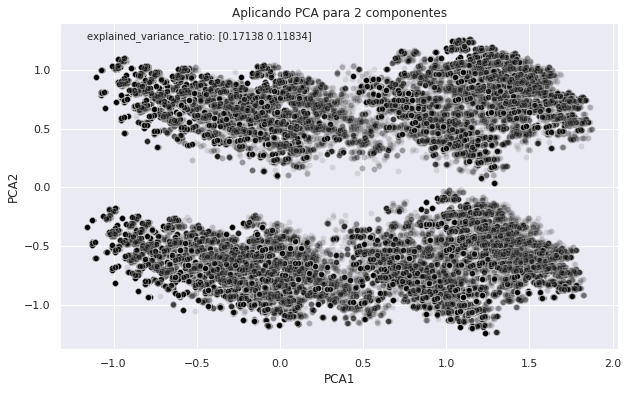

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], color='black', alpha=0.1)
ax.text(np.min(X_pca[:, 0]), np.max(X_pca[:, 1]), 
        f'explained_variance_ratio: {np.around(model_pca.explained_variance_ratio_, 5)}', fontsize=10) 

plt.title('Aplicando PCA para 2 componentes')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

## Referências

[Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

[Clusterização de Dados - PUC-RIO](https://www.maxwell.vrac.puc-rio.br/24787/24787_5.PDF)

[ML Data Pipelines with Custom Transformers in Python](https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65)

[Build your first Machine Learning pipeline using scikit-learn!](https://www.analyticsvidhya.com/blog/2020/01/build-your-first-machine-learning-pipeline-using-scikit-learn/)

[Pipeline da scikit learn](https://medium.com/databootcamp/pipeline-da-scikit-learn-e71c79ec744b)